In [1]:
# jupyter notebook go wide screen
# go wide screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


In [2]:
import matplotlib.pyplot as plt

In [3]:
# update matplotlib params for bigger font
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
plt.style.use("seaborn-whitegrid")

In [4]:
import numpy as np
import glob
from astropy.io import fits, ascii
from astropy.table import Table, join, vstack
import astropy.units as u
from astropy.coordinates import SkyCoord

from hetdex_api.shot import *
from hetdex_api.survey import Survey, FiberIndex
survey = Survey('hdr2')

In [ ]:
import holoviews as hv
from holoviews import opts
from holoviews.streams import Selection1D
hv.extension('bokeh')

In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [7]:
def load_shot(shot):
        fileh = open_shot_file(shot)
        table = Table(fileh.root.Data.Fibers.read())
        fileh.close()
        return table

In [8]:
def_wave = np.arange(3470, 5542, 2)
len(def_wave)

1036

In [13]:
laeinfo = ascii.read("catalogs/goodlaes.cat")
for shot in np.unique(laeinfo["shotid"]):
    tmp = len(laeinfo[laeinfo["shotid"]==shot])
    if tmp > 5:
        print(shot, tmp)

20180513007 6
20180515009 7
20180516017 8
20180520010 8
20190101015 8
20190104025 11
20190105011 6
20190105013 6
20190105025 6
20190105027 8
20190105030 8
20190112027 8
20190112028 6
20190112029 9
20190112030 9
20190116018 7
20190202014 12
20190202016 9


In [14]:
myshot = 20190202014

In [15]:
table = load_shot(shot)

In [16]:
tsne = TSNE()
pca = PCA(n_components=51)

In [17]:
X = table["spec_fullsky_sub"].data
X[X==0.0] = np.nan
X.shape

(64512, 1036)

In [18]:
means, stds = np.nanmedian(X, axis=0), np.nanstd(X, axis=0)
print(means.shape, stds.shape)

(1036,) (1036,)


In [19]:
Y = (X-means)/stds
mask = []
for x in Y:
    if len(np.unique(x)) == 1:
        mask.append(False)
    else:
        mask.append(True)
Y = Y[mask]
Y[Y==0.0] = np.nan
Y.shape

(64512, 1036)

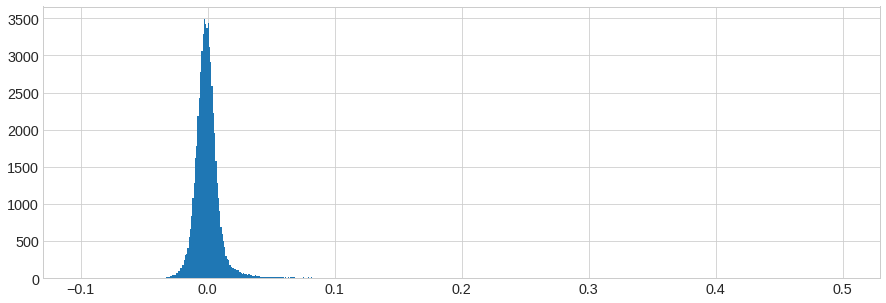

In [20]:
mids = np.nanmedian(Y, axis=1)
plt.hist(mids, np.arange(-0.1,0.5, 0.001));

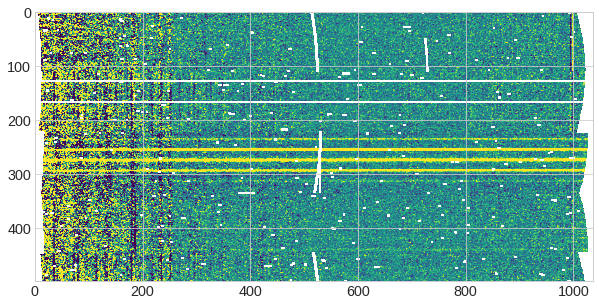

In [21]:
plt.figure(figsize=(10,100))
plt.imshow(Y[:500], cmap="viridis", vmin=-0.1, vmax=0.1)
#plt.yticks(np.arange(len(Y))[cont], ["x" for i in range(len(cont[cont]))]);

In [22]:
Y[~np.isfinite(Y)] = 0.0
Y_transformed = pca.fit_transform(Y)
Y_transformed.shape

(64512, 51)

In [23]:
X_embedded = tsne.fit_transform(Y_transformed)

In [24]:
X_embedded.shape

(64512, 2)

In [25]:
cont = mids > 0.15
smaller = (mids<-0.08)
larger = (mids> 0.08)

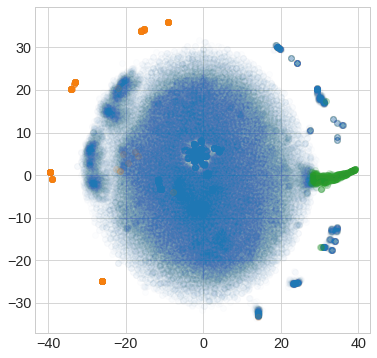

In [26]:
plt.figure(figsize=(6,6))
plt.scatter(X_embedded[:,0], X_embedded[:,1], alpha=0.01)
plt.scatter(X_embedded[:,0][smaller], X_embedded[:,1][smaller], alpha=0.1)
plt.scatter(X_embedded[:,0][larger], X_embedded[:,1][larger], alpha=0.1)

## try holoviews

In [27]:
transformed_i = np.column_stack((X_embedded ,range(len(X_embedded))))
transformed_i = [tuple(transformed_i[j]) for j in range(len(transformed_i))]
transformed_i = np.array(transformed_i)
print(transformed_i.shape)
filenames = [str(i) for i in range(len(X_embedded))]
spectra = X[mask]

#ascii.write({"tsne_1": transformed_i[:,0],"tsne_2": transformed_i[:,1],"idx": transformed_i[:,2]}, "tsne_coords.dat", overwrite=True)
#with open("spectra_tsne.dat" , "w") as sp:
#    for i in range(len(spectra)):
#        sp.write(" ".join(np.array(spectra[i], dtype=str)) + "\n")
#sp.close()

(64512, 3)


## try holoviews now

In [9]:
with open("spectra_tsne.dat" , "r") as sp:
    spectra = [x.split(" ") for x in sp.readlines()]
sp.close()

In [14]:
for i in range(len(spectra)):
    spectra[i][-1] = spectra[i][-1][:-1]

In [16]:
spectra = np.array(spectra, dtype=np.float)

In [18]:
transformed_i = ascii.read("tsne_coords.dat")#np.column_stack((X_embedded ,range(len(X_embedded))))
transformed_i = [tuple(transformed_i[j]) for j in range(len(transformed_i))]
filenames = [str(i) for i in range(len(transformed_i))]

In [21]:
spectral_data = hv.NdOverlay({int(i) : hv.Curve((def_wave, spectra[int(i)])) for _,_,i in transformed_i})

In [23]:
points = hv.Points(transformed_i, [r'First tSNE feature',r'Second tSNE feature'])

In [24]:
stream = Selection1D(source=points)

In [26]:
tools = ['box_select', 'lasso_select', 
	 'box_zoom', 'wheel_zoom', 'tap', 'reset']


In [28]:
empty = (hv.Points(np.random.rand(0,2)) * hv.Curve(np.random.rand(0,2))).relabel('No selection')


def get_spectra(index):
  
    if not index:
        print('No index!')
        print(' ')
        return empty
    else: print('There is an index!')
    spectrum = spectral_data[index[0]]
    curve =  hv.Curve(spectrum).relabel(filenames[index[0]])
    curve = curve.redim.label(x = r'Wavelength ($\AA$)', y = r'Flux (erg/s/$\mathrm{cm}^2$)')
    return curve

selected_spectra = hv.DynamicMap(get_spectra, kdims=[], streams=[stream])

#average = hv.Curve(points).aggregate(function=np.mean)


#points.opts(tools=tools) + selected_spectra.opts(width=700)

layout = (selected_spectra + points).cols(1)

layout.opts(
	opts.Curve(color='darkblue', width=583, height=233, framewise=True, align='center',tools=['zoom_out']),
	opts.Points(color='black', tools=tools, width=583,
                height=523,
		     marker='o', size=4, framewise=True, align='center', alpha=0.3),
	opts.Overlay(toolbar='above', legend_position='right',width=700))

#show(layout)

#fig = figure(title = 'tSNE', plot_height = 700, plot_width = 800,
#	     toolbar_location='below',
#	     tools=tools)

#fig.scatter(x = transformed[:,0], y = transformed[:,1],
#	   color='green', size=1.5, alpha=0.5)

#show(fig)

There is an index!


:Layout
   .DynamicMap.I :DynamicMap   []
      :Curve   [x]   (y)
   .Points.I     :Points   [First tSNE feature,Second tSNE feature]